In [1]:
%load_ext autoreload
%autoreload 2

from markovBike.manager.manager import Manager
from markovBike.data_source.source import database_queries, get_stations_data
from markovBike.model.model import full_transition_matrix

In [2]:
verbose = True

n_stations = 2_000

n_trips = 30_000_000

In [3]:
trips_raw = get_stations_data(database_queries(n_trips)['trips'], verbose=True)

probability_matrix = full_transition_matrix(trips_raw.sample(n=500_000))

Bike station table with shape (30000000, 15). Columns are: 

tripduration                             Int64
starttime                  datetime64[ns, UTC]
stoptime                   datetime64[ns, UTC]
start_station_id                         Int64
start_station_name                      object
start_station_latitude                 float64
start_station_longitude                float64
end_station_id                           Int64
end_station_name                        object
end_station_latitude                   float64
end_station_longitude                  float64
bikeid                                   Int64
usertype                                object
birth_year                               Int64
gender                                  object
dtype: object

The length of the dictionary is 650
(650, 650)
(650, 650)
(650, 650)


In [4]:
import numpy as np

len(np.unique(probability_matrix[0]))

7721

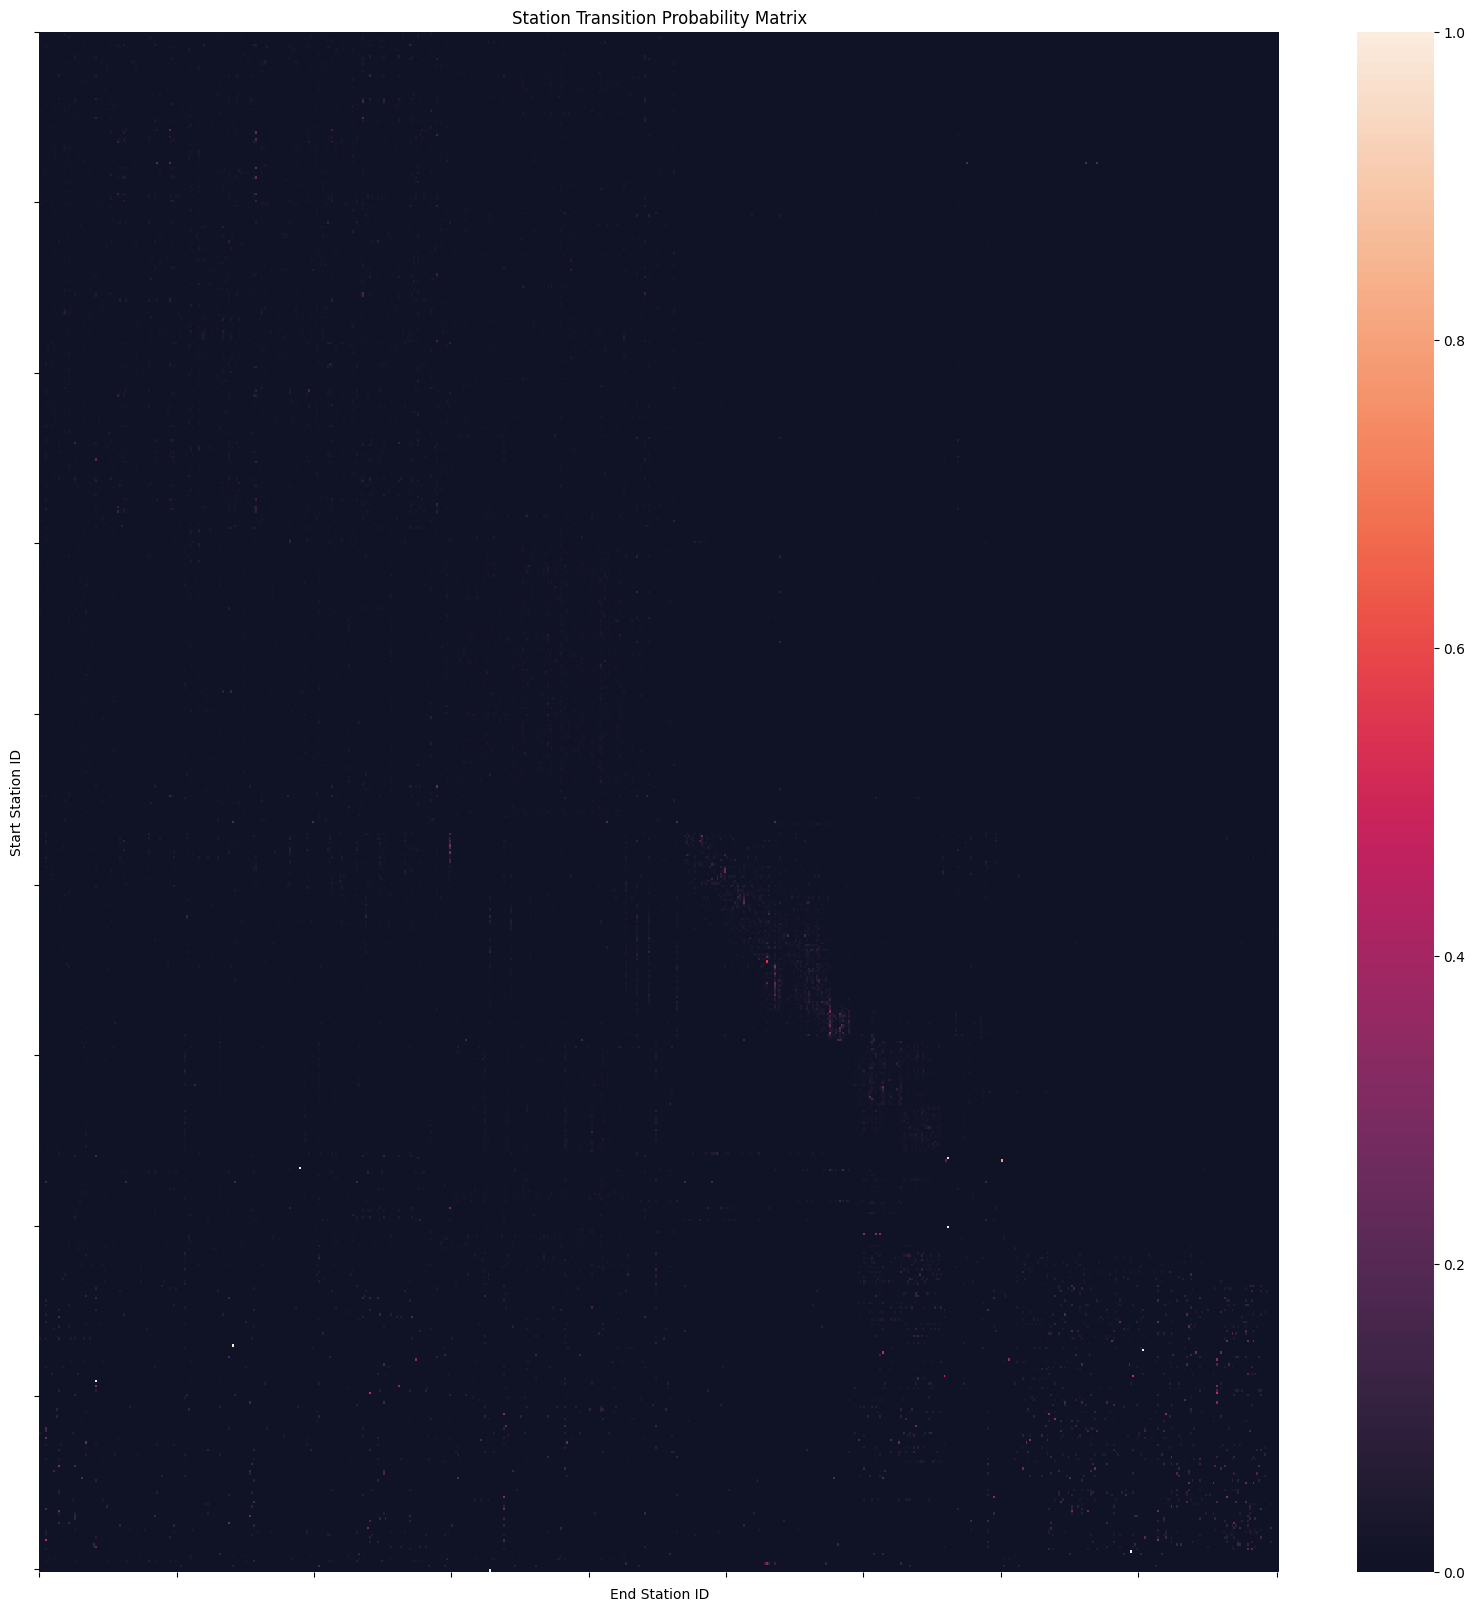

In [14]:
import seaborn as sns

Manager.transition_matrix_heatmaps(probability_matrix[0])


In [15]:
len(np.unique(probability_matrix[1]))

2

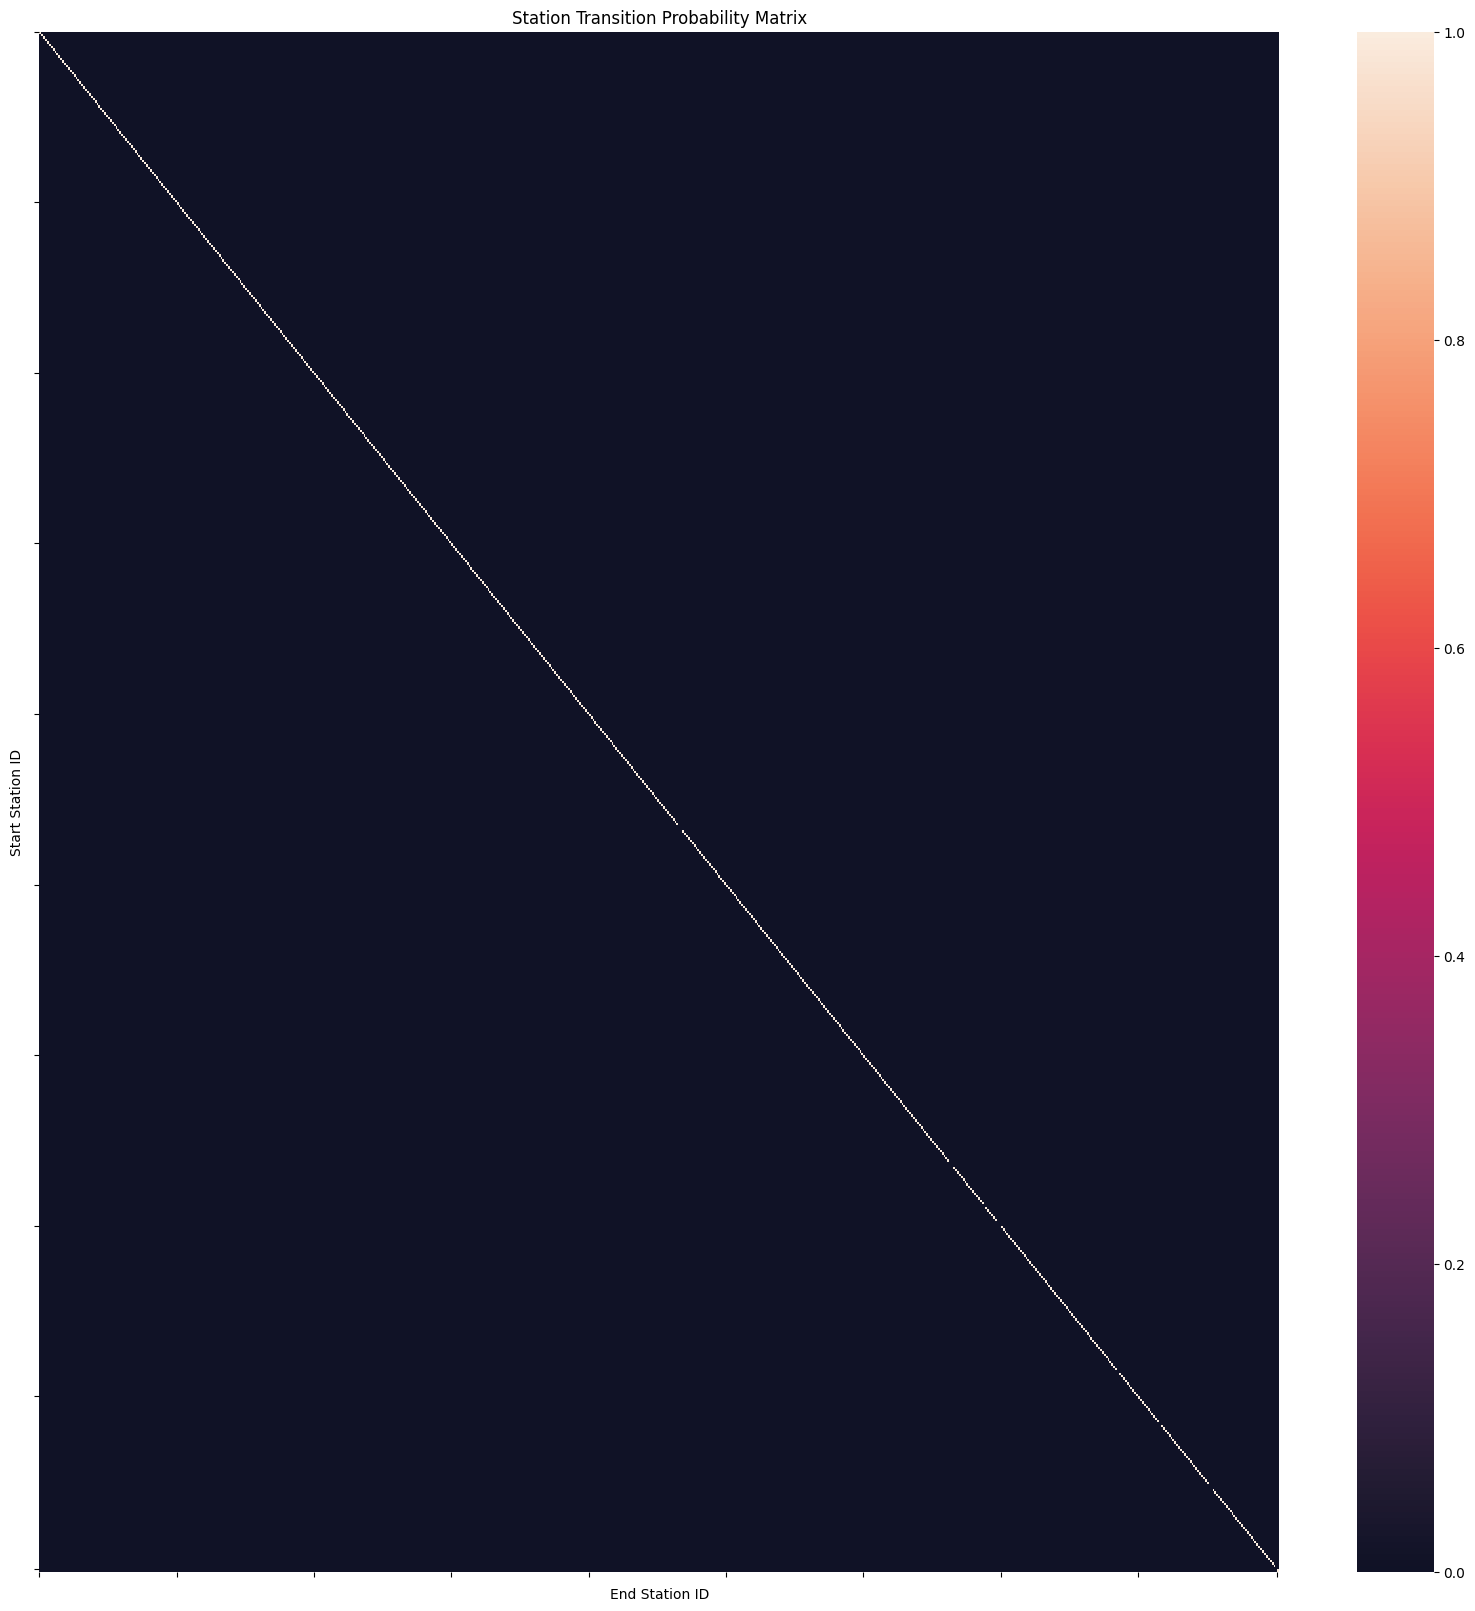

In [16]:
Manager.transition_matrix_heatmaps(probability_matrix[1])

In [17]:
len(np.unique(probability_matrix[2]))

8043

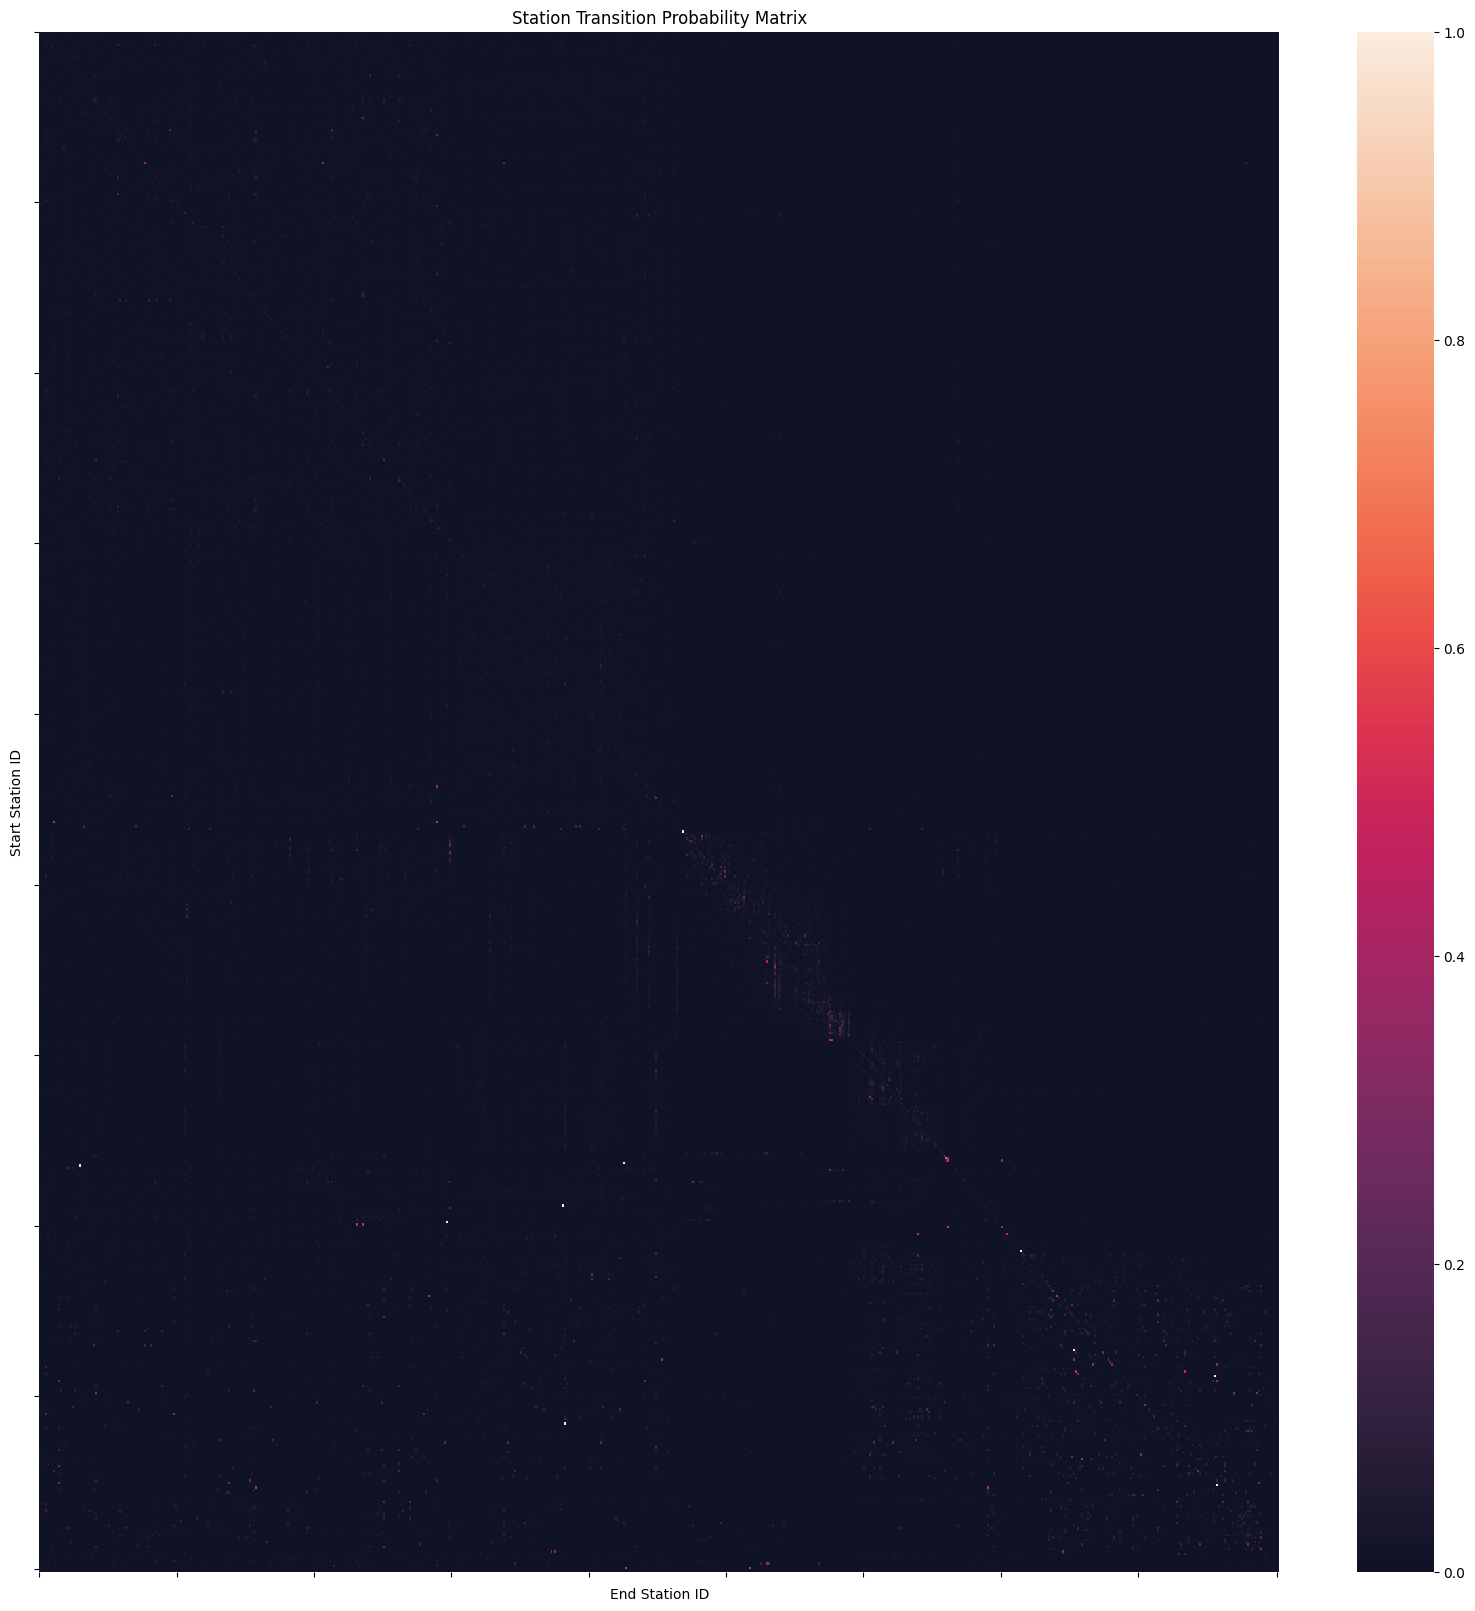

In [18]:
Manager.transition_matrix_heatmaps(probability_matrix[2])

In [19]:
len(np.unique(probability_matrix[3]))

25071

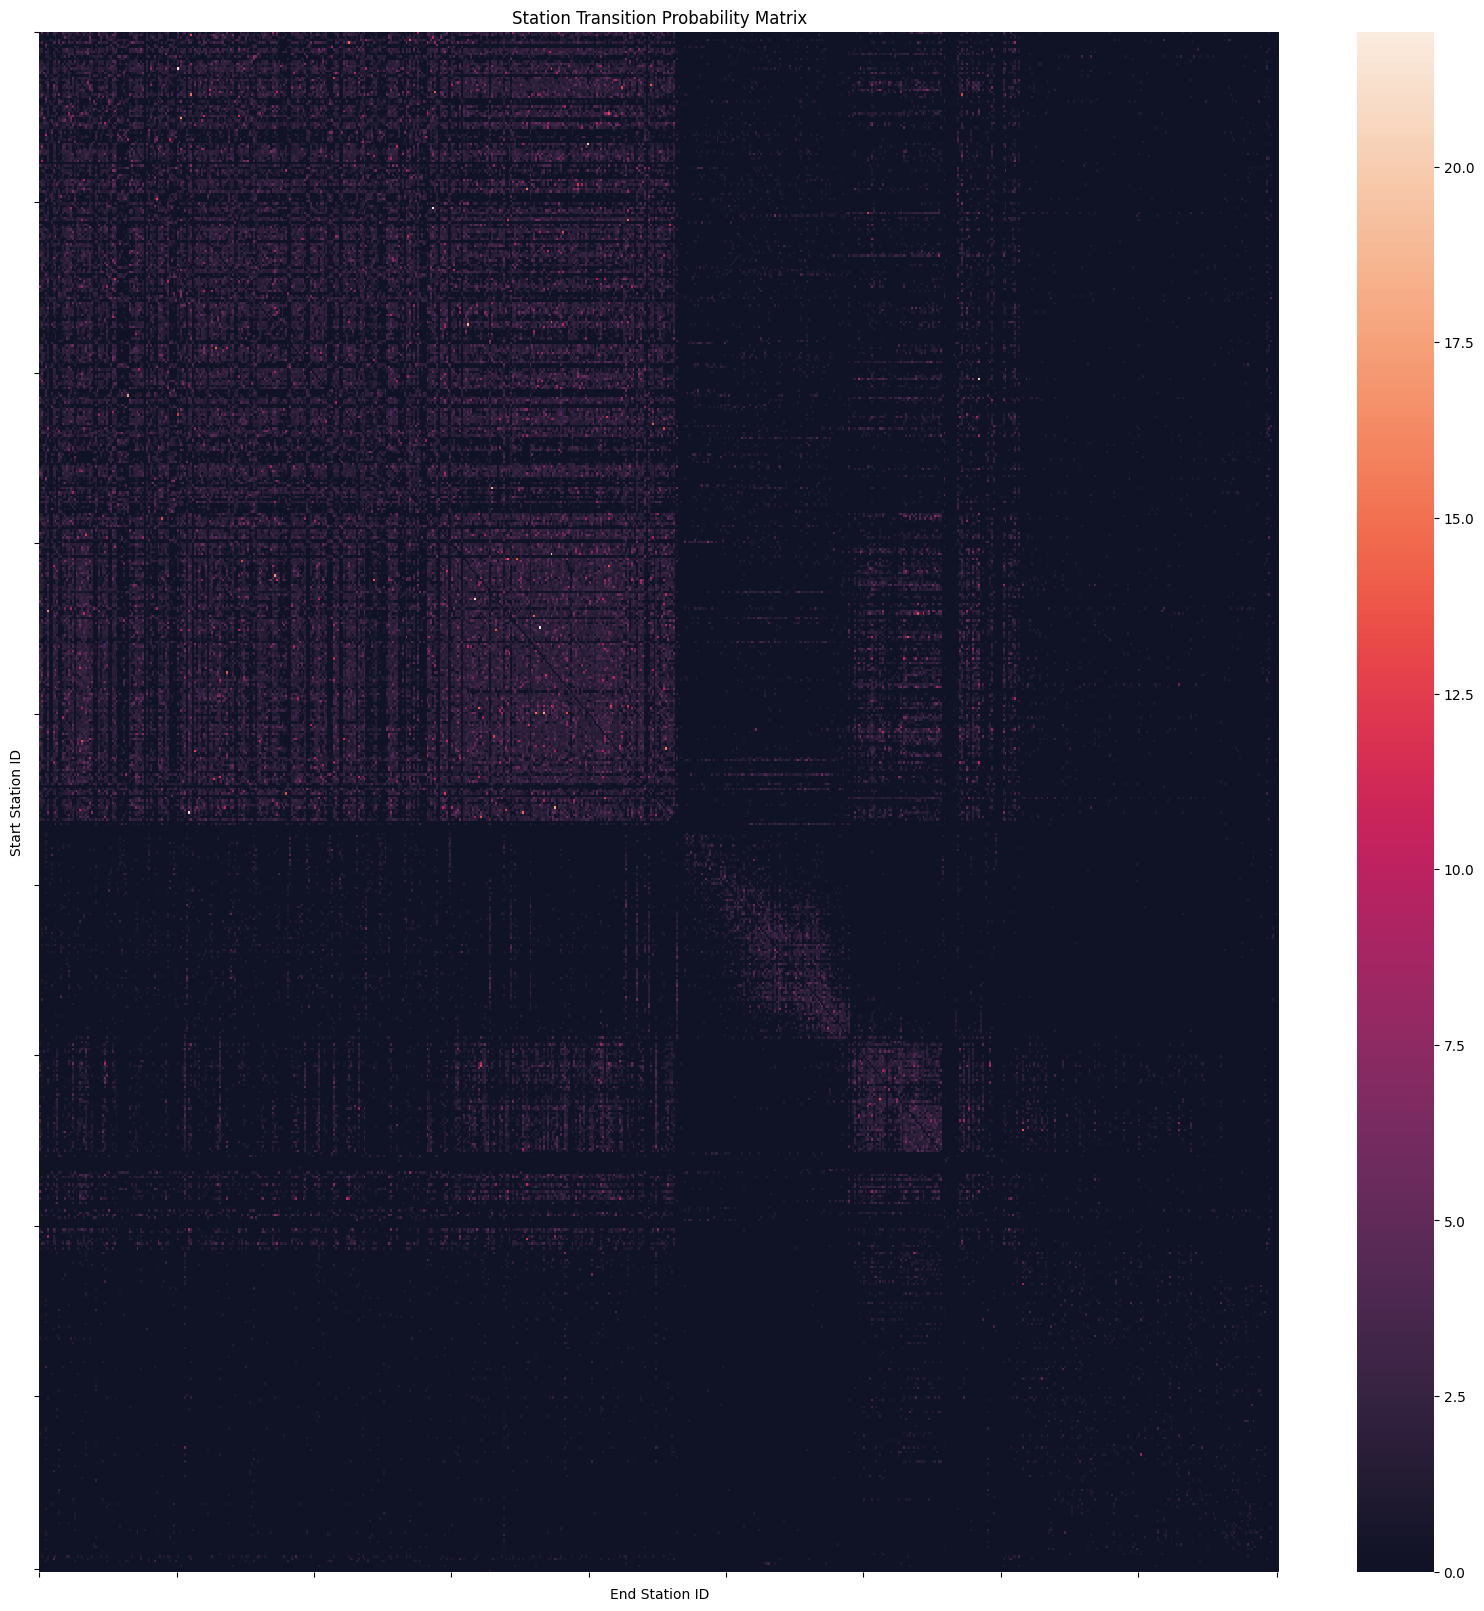

In [20]:
Manager.transition_matrix_heatmaps(probability_matrix[3])